In [1]:
import numpy as np
from copy import copy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from tqdm import tqdm
import math
import random
from tqdm import tqdm
import seaborn as sns
import scipy
from copy import deepcopy

np.set_printoptions(precision=3)

In [2]:
def plot_policy(svalues):
    """Plot gridworld arrows"""
    rows = np.shape(svalues)[0]
    cols = np.shape(svalues)[1]
    grid = np.empty((rows, cols), dtype='<U4')

    for i in range(rows):
        for j in range(cols):
            grid_val = dict() 
            if i-1 >= 0 and i-1 >=0 and i < rows: # Up
                #print(f"UP: svalues[{i}, {j}]: {svalues[i, j]} --- svalues[{i-1}, {j}]: {svalues[i-1, j]}")
                grid_val["U"] = svalues[i-1, j]
            if i+1 < np.shape(svalues)[0] and i >=0 and i+1 < rows: # Down
                #print(f"DOWN: svalues[{i}, {j}]: {svalues[i, j]} --- svalues[{i+1}, {j}]: {svalues[i+1, j]}")
                grid_val["D"] = svalues[i+1, j]
            if j-1 < np.shape(svalues)[0] and j-1 >=0 and j < cols: # Left
                #print(f"LEFT: svalues[{i}, {j}]: {svalues[i, j]} --- svalues[{i}, {j-1}]: {svalues[i, j-1]}")
                grid_val["L"] = svalues[i, j-1]
            if j+1 < np.shape(svalues)[0] and j >=0 and j+1 < cols: # Right
                #print(f"RIGHT: svalues[{i}, {j}]: {svalues[i, j]} --- svalues[{i}, {j+1}]: {svalues[i, j+1]}")
                grid_val["R"] = svalues[i, j+1]

            for k, v in grid_val.items():
                #print(grid_val)
                if round(v, 3) >= round(max(grid_val.values()), 3):
                    #print(grid)
                    grid[i,j] += k

    arrows = {
        "R": (1, 0),
        "L": (-1, 0),
        "U": (0, -1),
        "D": (0, 1),
        "UR": (1, -1),
        "LU": (-1, -1),
        "RD": (1, 1),
        "LD": (-1, 1),
    }
    scale = 0.25
    n_rows, n_cols = len(grid), len(grid[0])
    fig, ax = plt.subplots(figsize=(n_cols, n_rows))
    ax.set_xticks(np.arange(0.5, n_cols, 1))
    ax.set_yticks(np.arange(0.5, n_rows, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    action_arrows = {
        'R': (1, 0),
        'L': (-1, 0),
        'U': (0, -1),
        'D': (0, 1),
    }

    for i in range(n_rows):
        for j in range(n_cols):
            cell = grid[i][j]
            x = j
            y = i  # Corrected the y coordinate

            for direction in cell:
                dx, dy = action_arrows.get(direction, (0, 0))

                if direction != ' ':
                    ax.arrow(x, y, scale * dx, scale * dy, head_width=0.1, head_length=0.1, fc='b', ec='b')

    plt.gca().invert_yaxis()
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.show()

# Question 1

In [236]:
class Env:
    def __init__(self, n_arms, mu=0, sigma=1, seed=42, verbose=True):
        self.n_arms = n_arms
        self.action_space = n_arms
        self.q_a = np.random.normal(mu, sigma, n_arms)  # mean (mu), and standard deviation (sigma) for generating random rewards for each arm.
        self.seed = seed
        self.verbose = verbose
        self.current_state = "red" if random.random() < 0.5 else "green" # Initialize the current state
        #self.r = np.zeros_like(self.q_a)
        random.seed(self.seed)
        

    def pull_slot(self, a, num_state=1, rand_seed=42):
        """
        Takes an action, and return the actual reward Rt which is q(At) plus noise N(0,1)
        See book pg 34
        Arg:
            a (int): Integer from 0 to (self.n_arms-1)
        Return:
            r (float)
        """
        
        if num_state == 2:
            if self.current_state == "green":
                if a < 5:
                    r = 3*(self.q_a[a] + np.random.normal(0))
                else:
                    r = self.q_a[a] + np.random.normal(0)
            else:
                 r = self.q_a[a] + np.random.normal(0)
        else:
            r = self.q_a[a] + np.random.normal(0)
       
        #print("action: ", a)
        #print("reward (initial): ", r_init)
        #print("reward (given): ", r, "\n")
        return r
    
    def switch_state(self):
        """
        Change the background state
        """
        prob_switch = random.random() < 0.5 # 50% probability of switching background state
        if prob_switch:
            self.current_state = "red" if self.current_state == "green" else "green"
        #print("logic for switch is: ", prob_switch)
        

In [237]:
class player:
    def __init__(self, epsilon, Env, selection_type, c=None, initial_value=0, verbose=True, num_state=1):
        self.epsilon = epsilon
        self.Env = Env
        self.c = c
        self.selection_type = selection_type
        self.Q_a = np.full_like(Env.q_a, initial_value) if self.selection_type == "Optimistic Intial Value" else np.zeros_like(Env.q_a)
        self.N_a = np.zeros_like(self.Q_a)  # number of times each action had been chosen
        self.average_reward = 0
        self.r_history = []
        self.t = 1
        self.iter_num = 0
        self.verbose = verbose
        self.num_state = num_state
        
    def step(self):  # called at each time step and implements the epsilon-greedy action selection strategy
        """
        Return:
            A: discrete action selected from action space
        """
        
        if self.selection_type == "Epsilon Greedy" or self.selection_type == "Optimistic Intial Value":
            # select action according to epsilon greedy
            if np.random.random() < self.epsilon:
                A = np.random.choice(self.Env.action_space)
            else:
                A = np.argmax(self.Q_a)

        if self.selection_type == "Upper Confidence Bound":
            A = np.argmax(self.Q_a + self.c*np.sqrt(math.log(self.t)/(self.N_a+1)))
            self.t += 1
  
        if self.selection_type == "Thomson Sampling":
            # Sample from normal distribution
            sampled_values = np.random.normal(self.Q_a, np.sqrt(1 / (self.N_a + 1)))   
            
            # Select arm with highest sampled value
            A = np.argmax(sampled_values)               
        
        # get reward from environment
        R = self.Env.pull_slot(A, num_state=self.num_state)
        
        if self.num_state == 2:
            self.Env.switch_state()
        
        # Update Q_a, which is agent's estimate of the true Q_a
        self.N_a[A] += 1
        n_A = self.N_a[A]    # number of times action had been performed so far
        #print(self.Q_a[0])
        self.Q_a[A] += 1/n_A * (R - self.Q_a[A])
        
        # Update average reward within self attribute
        self.r_history.append(R)
        # self.average_reward += 1/n * (R - self.average_reward)

In [238]:
def run_experiment(epsilon, selection_type, initial_value=0, c=None, num_state=1, verbose=False):
    
    for epsilon in epsilon:
        historyA = {}
        historyB = {}
        print("Epsilon: ", epsilon)
        for x in range(steps):
            historyA[x] = []
            historyB[x] = []
        average_return_per_step = []
        return_at_step = []

        for _ in tqdm(range(N_expt)):
            ## Need to create a NEW Environment each time, because q_a is random
            multi_bandit = Env(n_arms)
            agent_01 = player(epsilon, multi_bandit, selection_type=selection_type, initial_value=initial_value, c=c, verbose=verbose, num_state=num_state)

            for i in range(steps):
                agent_01.step()
                historyA[i].append(np.mean(agent_01.r_history))   
                historyB[i].append(agent_01.r_history[-1])

            # del multi_bandit, agent_01

        # print("Stats for the last experiment")
        # print("Env.q_a: ", agent_01.Env.q_a)
        # print("Agent's Q(a)", agent_01.Q_a)
        # print("Agent's N(a)", agent_01.N_a)

        for i in historyA.keys():
            average_return_per_step.append(
                np.average(historyA[i])
            )
            return_at_step.append(
                np.average(historyB[i])
            )

        key = f"{selection_type}: ε={epsilon}, Q={initial_value}, c={c}, num_state={num_state}"
        all_average_return_per_step[key] = average_return_per_step
        all_return_at_step[key] = return_at_step

In [239]:
N_expt = 2000
steps = 1000
n_arms = 10
all_average_return_per_step = {}
all_return_at_step = {}

## Use Greedy Epsilon Selection

In [7]:
run_experiment(epsilon=[0.00, 0.01, 0.05, 0.10], selection_type="Epsilon Greedy")

Epsilon:  0.0


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:54<00:00, 17.50it/s]


Epsilon:  0.01


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:02<00:00, 16.26it/s]


Epsilon:  0.05


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:23<00:00, 13.98it/s]


Epsilon:  0.1


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:23<00:00, 13.92it/s]


## Q1 a) Use Optimistic Intial Value Selection

In [8]:
run_experiment(epsilon=[0.00], selection_type="Optimistic Intial Value", initial_value=5)

Epsilon:  0.0


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:30<00:00, 13.33it/s]


## Q1 b) Use Upper Confidence Bound Selection

In [9]:
run_experiment(epsilon=[0.00], selection_type="Upper Confidence Bound", c=1.5)

Epsilon:  0.0


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:47<00:00, 11.96it/s]


## Q1 c) Thomson Sampling Selection

In [10]:
run_experiment(epsilon=[0.00], selection_type="Thomson Sampling")

Epsilon:  0.0


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:31<00:00,  9.47it/s]


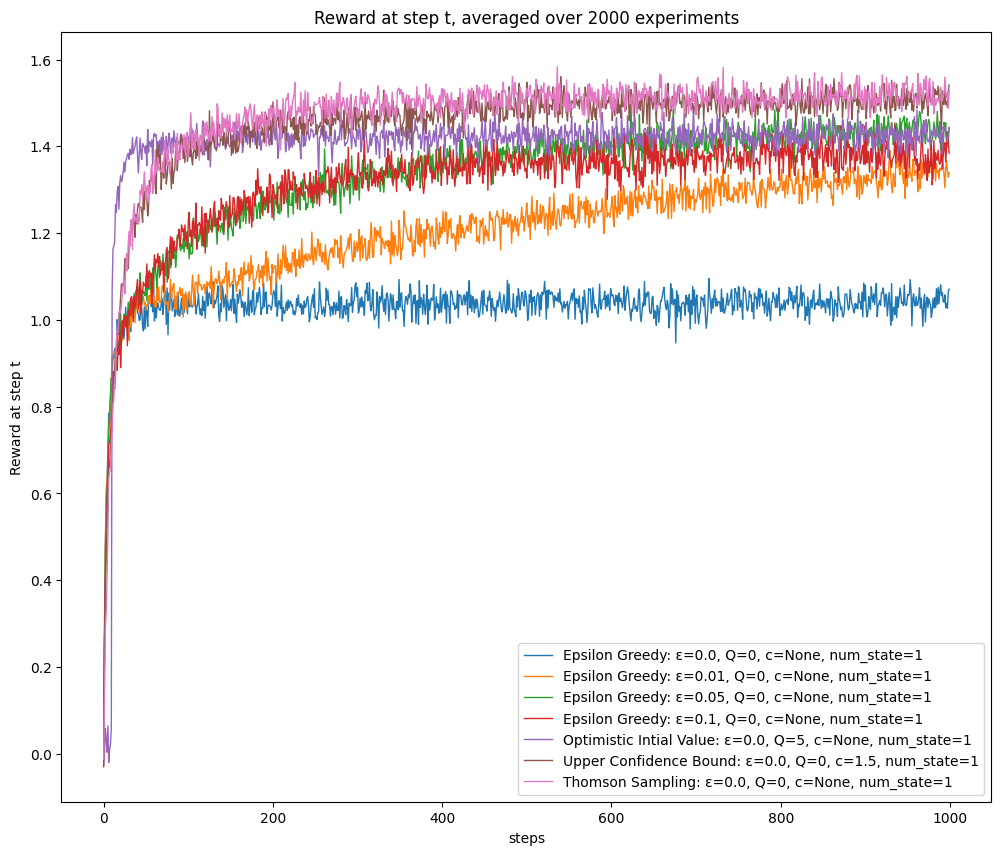

In [11]:
plt.figure(figsize=(12, 10))
for key, return_at_step in all_return_at_step.items():
    plt.plot(
        np.arange(steps)[:], return_at_step[:],
        linewidth=1, label=key
    )

plt.xlabel("steps")
plt.ylabel("Reward at step t")
plt.title("Reward at step t, averaged over %d experiments" % N_expt)
plt.legend(loc='lower right')
plt.show()

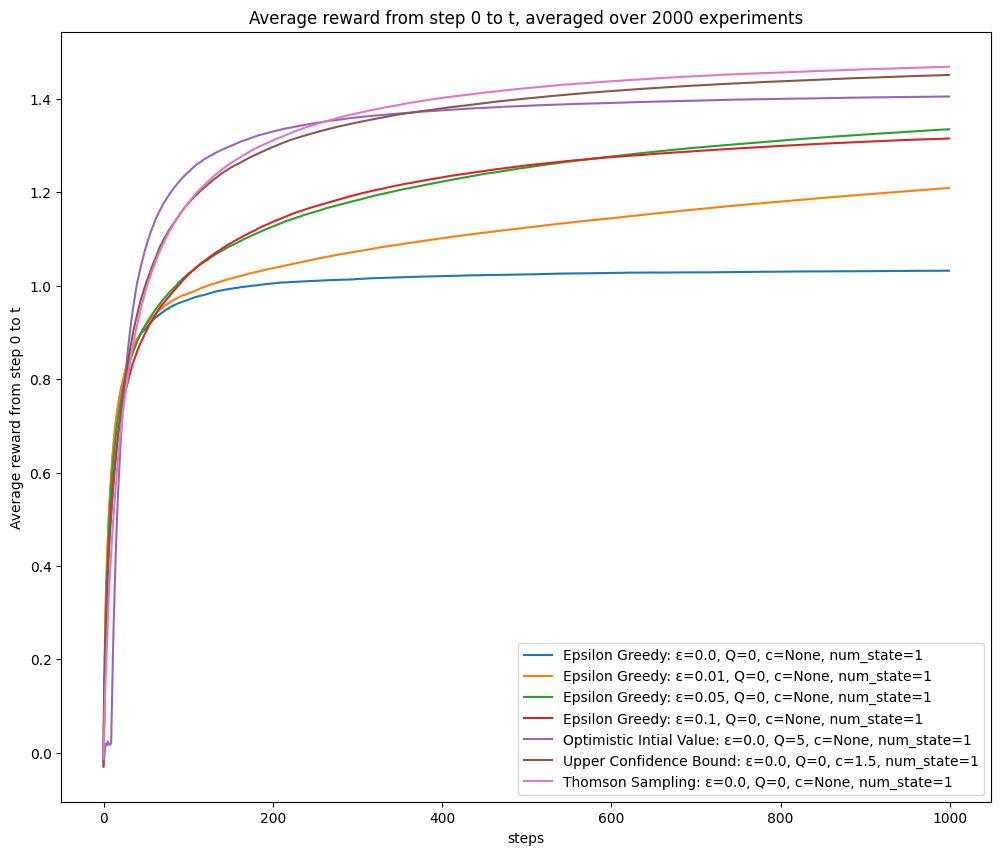

In [12]:
plt.figure(figsize=(12, 10))
for key, average_return_per_step in all_average_return_per_step.items():
    plt.plot(
        np.arange(steps)[:], average_return_per_step[:],
        label=key
    )

plt.xlabel("steps")
plt.ylabel("Average reward from step 0 to t")
plt.title("Average reward from step 0 to t, averaged over %d experiments" % N_expt)
plt.legend(loc='lower right')
plt.show()

## Q1 d) Two-State

In [256]:
N_expt = 2000
steps = 1000
n_arms = 10
all_average_return_per_step = {}
all_return_at_step = {}

In [257]:
run_experiment(epsilon=[0.00], selection_type="Thomson Sampling", num_state=2)

Epsilon:  0.0


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:50<00:00, 11.75it/s]


## Plot Results

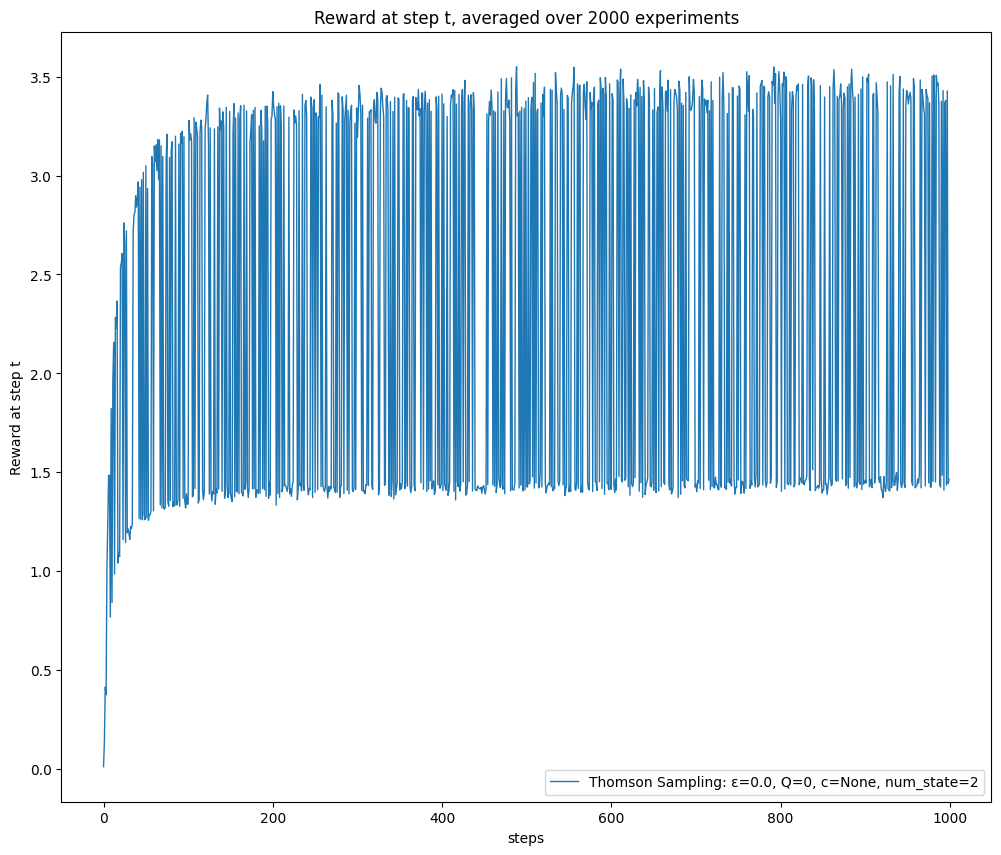

In [258]:
plt.figure(figsize=(12, 10))
for key, return_at_step in all_return_at_step.items():
    plt.plot(
        np.arange(steps)[:], return_at_step[:],
        linewidth=1, label=key
    )

plt.xlabel("steps")
plt.ylabel("Reward at step t")
plt.title("Reward at step t, averaged over %d experiments" % N_expt)
plt.legend(loc='lower right')
plt.show()

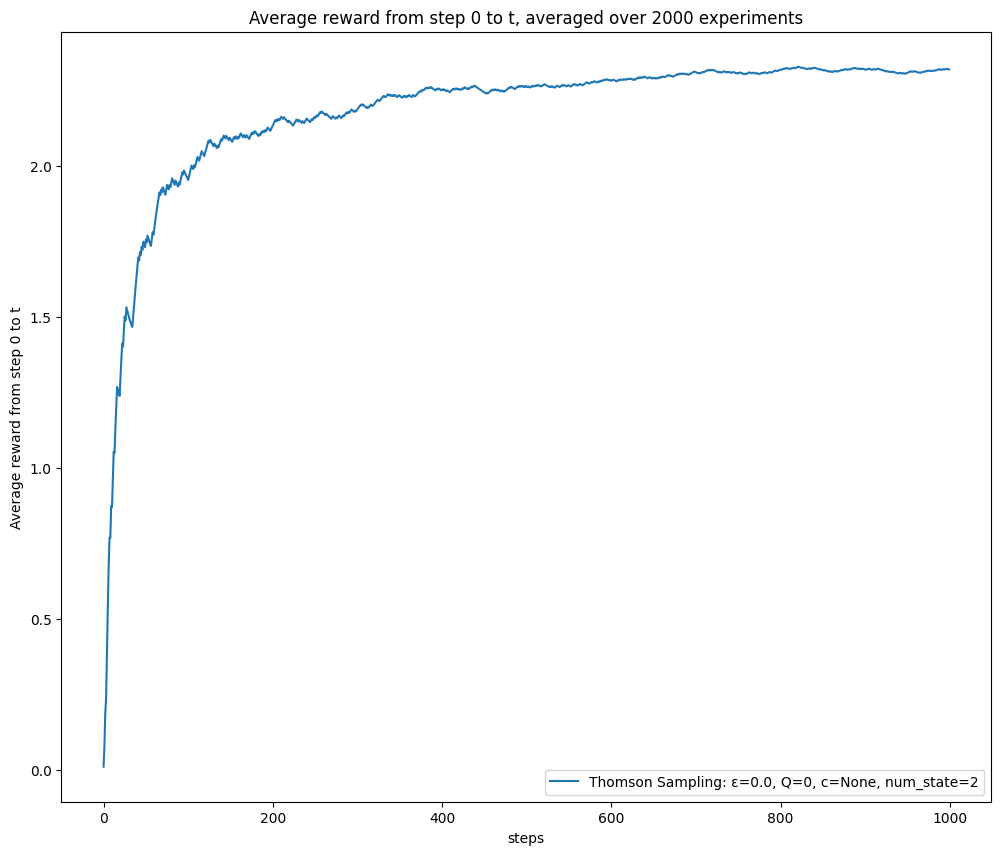

In [259]:
plt.figure(figsize=(12, 10))
for key, average_return_per_step in all_average_return_per_step.items():
    plt.plot(
        np.arange(steps)[:], average_return_per_step[:],
        label=key
    )

plt.xlabel("steps")
plt.ylabel("Average reward from step 0 to t")
plt.title("Average reward from step 0 to t, averaged over %d experiments" % N_expt)
plt.legend(loc='lower right')
plt.show()

### Question 2

## Q2 a)

In [266]:
class Env:
    def __init__(self):
        self.min_row = 0
        self.max_row = 4
        self.min_col = 0
        self.max_col = 4
    
    def transition(self, state, action):
        if state == [0,1]:
            state = [4,1]
            reward = 10
        elif state == [0,3]:
            state = [2,3]
            reward = 5
        else:
            if action == 0:
                state[1] += 1   # move right one column
            elif action == 1:
                state[0] += 1   # move down one row
            elif action == 2:
                state[1] -= 1   # move left one column
            elif action == 3:
                state[0] -= 1   # move up one row
            else:
                assert False, "Invalid action"
            
            if (state[0] < self.min_row) or (state[1] < self.min_col) or (state[0] > self.max_row) or (state[1] > self.max_col):
                reward = -1
            else:
                reward = 0
                
        # np.clip([1,1], [0,0], [4,4]).tolist()  -> [1, 1]
        # np.clip([1,5], [0,0], [4,4]).tolist()  -> [1, 4]        
        next_state = np.clip(state, [0,0], [4,4]).tolist()

        return reward, next_state  # rewards are awarded during transition when moving away from that state

In [18]:
class Explorer:
    def __init__(self, Env):
        self.Env = Env
        self.state = [0,0]   # list indicating row and column
        self.policy = lambda s: np.random.choice(4)
        self.v_s = np.zeros((self.Env.max_row+1, self.Env.max_col+1))
        self.gamma = 0.9
        self.actions = [0, 1, 2, 3]
    
    def step(self, learn=True):
        # action = np.random.choice(4)   # 0:right, 1:down, 2:left, 3:up
        action = self.policy(self.state)
        
        # reward, self.state = self.Env.transition(self.state, action)
        cur_state = self.state
        reward, next_state = self.Env.transition(deepcopy(cur_state), action)
        
        if learn is True:
            self.learn_value_fn()
            
        self.state = next_state
        return reward
    
    def learn_value_fn(self):
        """
        Using dynamic programming to update the state value function with the Bellman equation
        """
        state_values_new = np.zeros_like(self.v_s) # Initialize the state value array
        # Iterate through the entire array and update the value function dynamically
        for i in range(self.Env.max_row + 1):
            for j in range(self.Env.max_col + 1):                
                cur_state = [i, j] # Set the current state 
                for action in self.actions:
                    # Retrieve the reward and next state
                    reward, next_state = self.Env.transition(state=deepcopy(cur_state), action=action)
                    # The probability is set to 25% because each action (up, down, left, right) has equal probability of happening
                    state_values_new[i, j] += 0.25*(reward + self.gamma*self.v_s[next_state[0], next_state[1]])
        # Update the state value function
        self.v_s = state_values_new
        
    def run(self, n_iter=10000):
        G = 0
        self.history_r = []
        self.history_G = []
        for _ in tqdm(range(n_iter)):
            r = self.step()
            G += r
            self.history_r.append(r)
            self.history_G.append(G)
        
        fig, axes = plt.subplots(1,2,figsize=(8,4))
        axes[0].hist(self.history_r, bins=20)
        axes[0].set_title('Distribution of rewards at each step')
        axes[1].plot(self.history_G)
        axes[1].set_title('Cummulative total return from t=0')
        plt.show()


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [02:44<00:00, 303.23it/s]


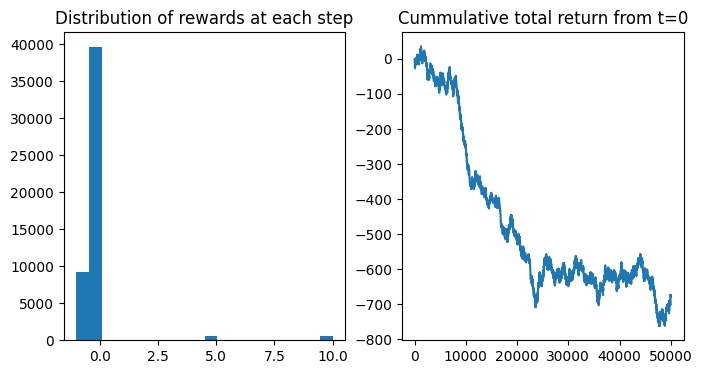

In [19]:
env = Env()
agent = Explorer(env)
agent.run(50000)

[[ 3.309  8.789  4.428  5.322  1.492]
 [ 1.522  2.992  2.25   1.908  0.547]
 [ 0.051  0.738  0.673  0.358 -0.403]
 [-0.974 -0.435 -0.355 -0.586 -1.183]
 [-1.858 -1.345 -1.229 -1.423 -1.975]]


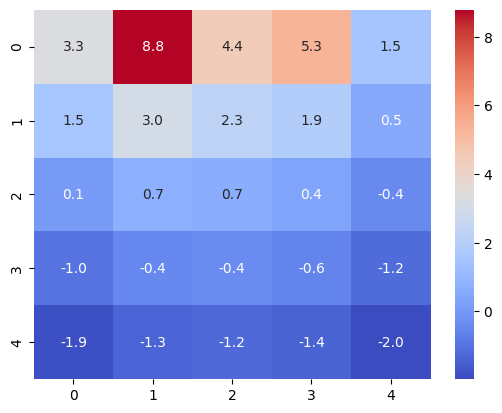

In [20]:
print(agent.v_s)
sns.heatmap(
    agent.v_s, annot=True, cmap='coolwarm', fmt='.1f'
)
plt.show()

## Q2 b)

In [21]:
class Explorer:
    def __init__(self, Env):
        self.Env = Env
        self.state = [0, 0]  # list indicating row and column
        self.policy = lambda s: np.random.choice(4) 
        self.policy_tracker = np.zeros((self.Env.max_row + 1, self.Env.max_col + 1), dtype=int)
        self.v_s = np.zeros((self.Env.max_row + 1, self.Env.max_col + 1))
        self.gamma = 0.9
        self.actions = [0, 1, 2, 3] # R D L U
        self.action_mapping = {0: "R", 1: "D", 2: "L", 3: "U"}
        
    def step(self, learn=True):
        action = self.policy(self.state)

        cur_state = self.state
        reward, next_state = self.Env.transition(deepcopy(cur_state), action)

        if learn:
            self.learn_value_fn()

        self.state = next_state
        #print(reward)
        return reward

    def learn_value_fn(self):
        # Initialize state value array
        state_values_new = np.zeros_like(self.v_s)
        for i in range(self.Env.max_row + 1):
            for j in range(self.Env.max_col + 1):
                # Set current state
                cur_state = [i, j]
                # Calculate values for all actions
                v_values = np.zeros(len(self.actions))
                for action in self.actions:
                    # Retrieve reward and next state
                    reward, next_state = self.Env.transition(state=deepcopy(cur_state), action=action) 
                    # Store the values for a given action
                    v_values[action] = reward + self.gamma * self.v_s[next_state[0], next_state[1]]

                # Update the sate value with the the optimal value for all actions 
                state_values_new[i, j] = np.max(v_values)
                # Find the indices of the tied values
                tied_indices = np.where(v_values == np.max(v_values))[0]
                # Randomly choose one value as a tie breaker
                tie_breaker_choice = random.choice(tied_indices)
                # Update the policy tracker to keep of the optimal action
                self.policy_tracker[i, j] = tie_breaker_choice
        # Update the state value function
        self.v_s = state_values_new

    def run(self, n_iter=10000):
        G = 0
        self.history_r = []
        self.history_G = []
        for _ in tqdm(range(n_iter)):
            r = self.step()
            G += r
            self.history_r.append(r)
            self.history_G.append(G)

        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        axes[0].hist(self.history_r, bins=20)
        axes[0].set_title('Distribution of rewards at each step')
        axes[1].plot(self.history_G)
        axes[1].set_title('Cumulative total return from t=0')
        plt.show()


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [03:22<00:00, 247.05it/s]


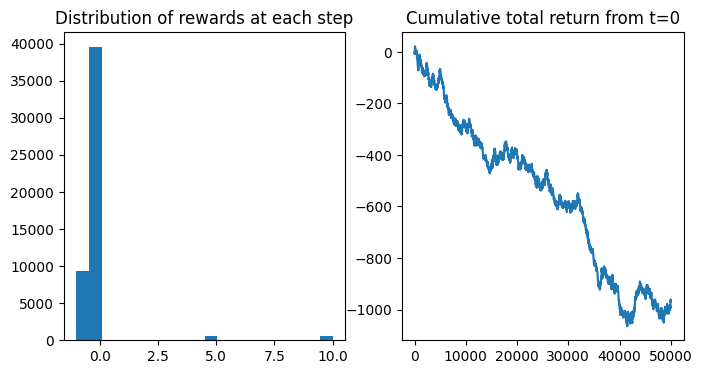

In [22]:
env = Env()
agent = Explorer(env)

agent.run(50000)

[[21.977 24.419 21.977 19.419 17.477]
 [19.78  21.977 19.78  17.802 16.022]
 [17.802 19.78  17.802 16.022 14.419]
 [16.022 17.802 16.022 14.419 12.977]
 [14.419 16.022 14.419 12.977 11.68 ]]


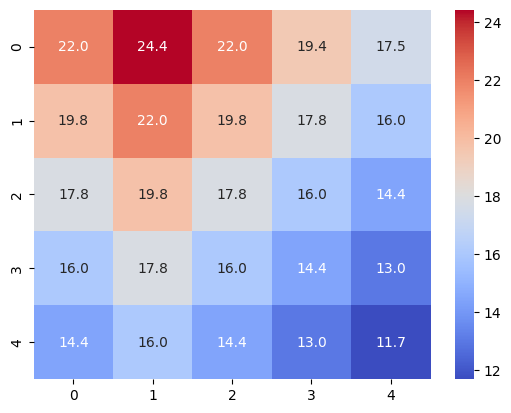

In [23]:
print(agent.v_s)

sns.heatmap(
    agent.v_s, annot=True, cmap='coolwarm', fmt='.1f'
)
plt.show()

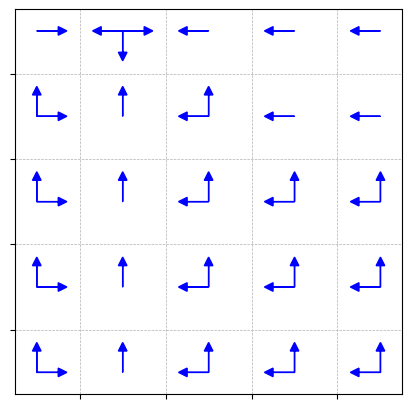

In [24]:
plot_policy(agent.v_s)

## Q2 c)

In [275]:
class Explorer:
    def __init__(self, Env):
        self.Env = Env
        self.state = [0, 0]
        self.policy = np.zeros((self.Env.max_row + 1, self.Env.max_col + 1), dtype=int)  # Initialize policy randomly
        self.v_s = np.zeros((self.Env.max_row + 1, self.Env.max_col + 1))
        self.gamma = 0.9
        self.actions = [0, 1, 2, 3]  # R, D, L, U
        self.action_mapping = {0: "R", 1: "D", 2: "L", 3: "U"}
        self.epsilon = 1e-5 # Intialize an epsilon value
        
    def evaluate_policy(self):
        """A method to evaluate a policy"""
        while True:
            delta = 0 # Initialize the delta value which represents the largest difference in state values
            for i in range(self.Env.max_row + 1):
                for j in range(self.Env.max_col + 1):
                    cur_state = [i, j] # Set the current state
                    action = self.policy[i, j] # Retrieve action based on the current position
                    old_v = self.v_s[i, j] # Retrieve existing state value at the current position
                    # Retrieve the reward and next state for the current state and action
                    reward, next_state = self.Env.transition(state=deepcopy(cur_state), action=action)
                    # Update the state value function for the current position
                    self.v_s[i, j] = reward + self.gamma * self.v_s[next_state[0], next_state[1]]
                    # Update delta as the larger of the delta value and the difference between the current and new state value
                    delta = max(delta, abs(old_v - self.v_s[i, j]))
            # Continue the while loop as long as delta is larger than epsilon
            if delta < self.epsilon:
                break
                
    def improve_policy(self):
        """A method to improve the policy
        Returns:
            Policy_stable (bool): A bolean value indicating whether the policy is stable
        """
        policy_stable = True # An intialized value representing the stability of the policy
        for i in range(self.Env.max_row + 1):
            for j in range(self.Env.max_col + 1):
                cur_state = [i, j]  # Set the current state
                old_action = self.policy[i, j]  # Retrieve previous action
                action_values = np.zeros(len(self.actions)) # Create an array to store the action values
                for action in self.actions: # Iterate through all actions
                    # Retrieve the reward and next state
                    reward, next_state = self.Env.transition(state=deepcopy(cur_state), action=action)
                    # Update the action value array for the current action
                    action_values[action] = reward + self.gamma * self.v_s[next_state[0], next_state[1]]
                # Update the policy with the best action
                self.policy[i, j] = np.argmax(action_values)
                # If the policy is still changing, set the policy_state variable to False
                if old_action != self.policy[i, j]:
                    policy_stable = False                    
        return policy_stable
        
    def policy_iteration(self):
        i = 0
        while True: 
            self.evaluate_policy() # Run the method to evaluate the policy
            policy_stable = self.improve_policy() # Run the method to improve the policy
            i += 1
            
            if policy_stable: # Continue the loop to evaluate and improve the policy for as long as the policy continues to change
                print("Iteration: ", i)
                break
        
    def run(self, n_iter=10000):
        G = 0
        self.history_r = []
        self.history_G = []
        for _ in tqdm(range(n_iter)):
            r = self.step()
            G += r
            self.history_r.append(r)
            self.history_G.append(G)

        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        axes[0].hist(self.history_r, bins=20)
        axes[0].set_title('Distribution of rewards at each step')
        axes[1].plot(self.history_G)
        axes[1].set_title('Cumulative total return from t=0')
        plt.show()

In [276]:
env = Env()
agent = Explorer(env)

agent.policy_iteration()

Iteration:  7


[[21.977 24.419 21.977 19.419 17.477]
 [19.78  21.977 19.78  17.802 16.022]
 [17.802 19.78  17.802 16.022 14.419]
 [16.022 17.802 16.022 14.419 12.977]
 [14.419 16.022 14.419 12.977 11.68 ]]


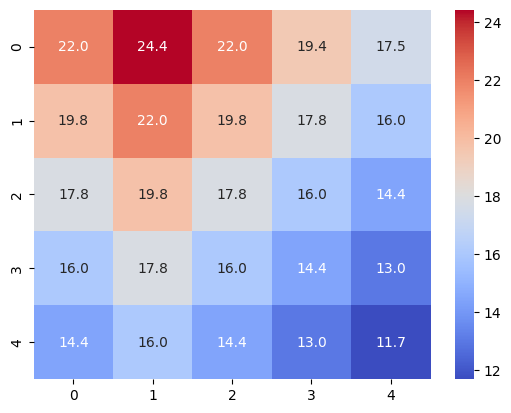

In [277]:
print(agent.v_s)

sns.heatmap(
    agent.v_s, annot=True, cmap='coolwarm', fmt='.1f'
)
plt.show()

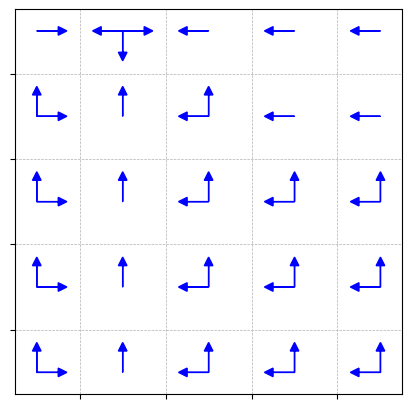

In [278]:
plot_policy(agent.v_s)